# SENTIMENT ANALYSIS WITH IMDB DATASET

In [2]:
#veri yükleme
#kaggle'den indirilen IMDB veri seti kullanıldı
#https://www.kaggle.com/berkantgnel
#üst linkte bulabilirsiniz

import pandas as pd
import numpy as np
import re
from bs4 import BeautifulSoup#html tagları ayirma icin
import nltk
from nltk.corpus import stopwords
from textblob import Word
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pickle

data = pd.read_csv('data/IMDB Dataset.csv')
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
data = pd.read_csv('data/IMDB Dataset.csv')
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [5]:
data['sentiment'].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

In [6]:
nltk.download('stopwords')
nltk.download('wordnet')

sw = stopwords.words('english')


def clean_text(text):
    #html taglari ayirma
    text = BeautifulSoup(text, 'html.parser').get_text()
    #kğcük harfe çevirme
    text = text.lower()
    #noktalama ve sayıları kaldırma
    text = re.sub(r'[^a-z\s]', '', text)
    #stopwordleri kaldırma
    text = ' '.join([word for word in text.split() if word not in sw])
    #lemmatization(stemming e alternatif hatta daha iyisidir kelimenin kok anlamını korur)
    text = ' '.join([Word(word).lemmatize() for word in text.split()])
    
    return text

data['clean_review'] = data['review'].apply(clean_text)

data[['review', 'clean_review']].head()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\MSI\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\MSI\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
C:\Users\MSI\AppData\Local\Temp\ipykernel_30400\589322348.py:9: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


,review,clean_review
0,One of the other reviewers has mentioned that ...,one reviewer mentioned watching oz episode you...
1,A wonderful little production. <br /><br />The...,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,basically there family little boy jake think t...
4,"Petter Mattei's ""Love in the Time of Money"" is...",petter matteis love time money visually stunni...


In [7]:
#feature extraction

X = data['clean_review']
y = data['sentiment']


train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)


vectorizer = CountVectorizer(max_features=5000)
#en sık kullanılan 5000 kelime
vectorizer.fit(train_x)

X_train = vectorizer.transform(train_x)
X_test = vectorizer.transform(test_x)

In [8]:
#tf-idf
#yani term frequency-inverse document frequency

tfidf = TfidfVectorizer(max_features=5000)
tfidf.fit(train_x)

X_train_tfidf = tfidf.transform(train_x)
X_test_tfidf = tfidf.transform(test_x)

In [9]:
#loj reg model eğitimi

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

loj_model = LogisticRegression(max_iter=1000)
loj_model.fit(X_train, train_y)


#predikasyon ve değerlendirme
y_pred = loj_model.predict(X_test)

print("Accuracy:", accuracy_score(test_y, y_pred))
print("Classification Report:\n", classification_report(test_y, y_pred))

print('\ntfidf ile değerlendirme:\n')

loj_model_tfidf = LogisticRegression(max_iter=1000)
loj_model_tfidf.fit(X_train_tfidf, train_y)

y_pred_tfidf = loj_model_tfidf.predict(X_test_tfidf)
print("Accuracy:", accuracy_score(test_y, y_pred_tfidf))
print("Classification Report:\n", classification_report(test_y, y_pred_tfidf))

Accuracy: 0.8726
Classification Report:
               precision    recall  f1-score   support

    negative       0.88      0.87      0.87      4961
    positive       0.87      0.88      0.87      5039

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000


tfidf ile değerlendirme:

Accuracy: 0.8853
Classification Report:
               precision    recall  f1-score   support

    negative       0.89      0.87      0.88      4961
    positive       0.88      0.90      0.89      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [10]:
#testtt
#tf-idf'i ana yöntem yaptık çünkü daha iyi sonuç verdi(%1 daha iyi evet evett)
new_yorum = pd.Series(["it's fucking disappointing and boring movie"])
new_yorum_vec = tfidf.transform(new_yorum)
print(loj_model_tfidf.predict(new_yorum_vec)[0])

negative


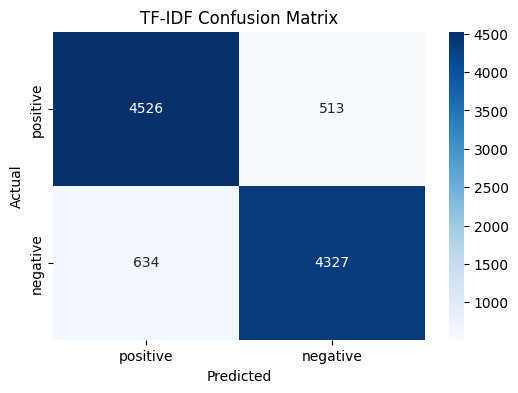

In [11]:
conf_matrix = confusion_matrix(test_y, y_pred_tfidf, labels=['positive', 'negative'])

plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['positive', 'negative'], yticklabels=['positive', 'negative'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('TF-IDF Confusion Matrix')
plt.show()

In [12]:
with open('models/sentiment_model_tfidf.pkl.pkl', 'wb') as f:
    pickle.dump(loj_model_tfidf, f)

with open('models/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf, f)

In [13]:
#kaydedilen model 
with open('models/sentiment_model_tfidf.pkl.pkl', 'rb') as f:
    loj_model_loaded = pickle.load(f)
with open('models/tfidf_vectorizer.pkl', 'rb') as f:
    tfidf_loaded = pickle.load(f)

new_yorum = pd.Series(["Thats a fantastic movie! I loved it. "])
new_yorum_vec = tfidf_loaded.transform(new_yorum)
new_yorum_pred = loj_model_loaded.predict(new_yorum_vec)
print("Prediction:", new_yorum_pred)

Prediction: ['positive']
